In [4]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [5]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define your scaling function
def custom_scaling_1(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    # input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Define

In [6]:
# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6


# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', 't_dt']].values
X_scaled = custom_scaling(X)
# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5]  # Number of hidden layers
Nh_values = [16, 32, 64, 128]  # Number of neurons per hidden layer

# Modular

## delta_current,delta_voltage

In [7]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_1 = df[["delta_current", "delta_voltage"]].values
# Define custom scaling ranges for each input feature

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_1, y_temp_1     = train_test_split(X_scaled, y_1, test_size=0.3, random_state=42)
X_val, X_test, y_val_1, y_test_1 = train_test_split(X_temp, y_temp_1, test_size=0.5, random_state=42)

histories_1 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_1 = {}
maes_1 = {}
rmses_1= {}
r2_scores_1 = {}
mapes_1 = {}



Epoch 1/100, Loss: 11.570685386657715, Val Loss: 8.51700210571289
Epoch 2/100, Loss: 7.932129859924316, Val Loss: 6.602957725524902
Epoch 3/100, Loss: 7.0855889320373535, Val Loss: 5.752841472625732
Epoch 4/100, Loss: 6.394920349121094, Val Loss: 4.902642250061035
Epoch 5/100, Loss: 5.659284591674805, Val Loss: 3.9744410514831543
Epoch 6/100, Loss: 5.226796627044678, Val Loss: 3.476757526397705
Epoch 7/100, Loss: 4.920918941497803, Val Loss: 3.2555181980133057
Epoch 8/100, Loss: 4.779909610748291, Val Loss: 2.950620174407959
Epoch 9/100, Loss: 4.674463748931885, Val Loss: 2.908318281173706
Epoch 10/100, Loss: 4.694507598876953, Val Loss: 2.83449125289917
Epoch 11/100, Loss: 4.642848968505859, Val Loss: 2.837461233139038
Epoch 12/100, Loss: 4.61359167098999, Val Loss: 2.884305000305176
Epoch 13/100, Loss: 4.521827697753906, Val Loss: 2.829878091812134
Epoch 14/100, Loss: 4.58917236328125, Val Loss: 2.846740245819092
Epoch 15/100, Loss: 4.502679824829102, Val Loss: 2.7547760009765625
E

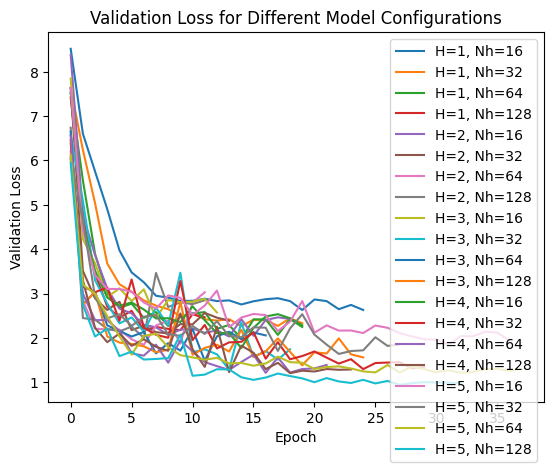

In [8]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_1 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_1.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_1.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_1.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_1.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_1.add(tf.keras.layers.Dense(2, activation='softplus'))  

        # Compile the model
        model_1.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_1 = model_1.fit(X_train, y_train_1, epochs=100, batch_size=32, validation_data=(X_val, y_val_1), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_1

        # Evaluate the model on the testing set
        predictions_1 = model_1.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_1 = model_1.evaluate(X_test, y_test_1)
        mses_1[(H, Nh)] = mse_1

        # Calculate Mean Absolute Error (MAE)
        mae_1 = mean_absolute_error(y_test_1, predictions_1)
        maes_1[(H, Nh)] = mae_1

        # Calculate Root Mean Squared Error (RMSE)
        rmse_1 = np.sqrt(mean_squared_error(y_test_1, predictions_1))
        rmses_1[(H, Nh)] = rmse_1

        # Calculate R-squared (R2) Score
        r2_1 = r2_score(y_test_1, predictions_1)
        r2_scores_1[(H, Nh)] = r2_1

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_1 = np.mean(np.abs((y_test_1 - predictions_1) / y_test_1)) * 100
        mapes_1[(H, Nh)] = mape_1

# Plot the validation loss for each configuration
for (H, Nh), history_1 in histories_1.items():
    plt.plot(history_1.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_1 in mses_1.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_1}')
#     print(f'MAE: {maes_1[(H, Nh)]}')
#     print(f'RMSE: {rmses_1[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_1[(H, Nh)]}')
#     print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [9]:
# Rank combinations based on their MSE values
ranked_combinations_1 = sorted(mses_1.items(), key=lambda x: x[1])

# Print ranked combinations
print('delta_current,delta_voltage')
for idx, ((H, Nh), mse_1) in enumerate(ranked_combinations_1, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_1}")


delta_current,delta_voltage
Rank 1: Combination H=5, Nh=128 - MSE: 0.9567629098892212
Rank 2: Combination H=4, Nh=128 - MSE: 1.1675236225128174
Rank 3: Combination H=5, Nh=64 - MSE: 1.2098568677902222
Rank 4: Combination H=4, Nh=64 - MSE: 1.2453370094299316
Rank 5: Combination H=3, Nh=128 - MSE: 1.2852495908737183
Rank 6: Combination H=4, Nh=32 - MSE: 1.2857803106307983
Rank 7: Combination H=3, Nh=32 - MSE: 1.3477473258972168
Rank 8: Combination H=3, Nh=64 - MSE: 1.3655972480773926
Rank 9: Combination H=5, Nh=32 - MSE: 1.6177632808685303
Rank 10: Combination H=4, Nh=16 - MSE: 1.7780346870422363
Rank 11: Combination H=2, Nh=64 - MSE: 1.7920818328857422
Rank 12: Combination H=5, Nh=16 - MSE: 1.8378970623016357
Rank 13: Combination H=2, Nh=128 - MSE: 1.9842008352279663
Rank 14: Combination H=1, Nh=64 - MSE: 2.008640766143799
Rank 15: Combination H=2, Nh=16 - MSE: 2.087031841278076
Rank 16: Combination H=2, Nh=32 - MSE: 2.1154167652130127
Rank 17: Combination H=1, Nh=128 - MSE: 2.145524740

## Pl_s1,Pl_s2

In [10]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_2 = df[["Pl_s1"]].values  # Adjust column names as per your dataset

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_2, y_temp_2 = train_test_split(X_scaled, y_2, test_size=0.3, random_state=42)
X_val, X_test, y_val_2, y_test_2 = train_test_split(X_temp, y_temp_2, test_size=0.5, random_state=42)


histories_2 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_2 = {}
maes_2 = {}
rmses_2= {}
r2_scores_2 = {}
mapes_2 = {}

Epoch 1/100, Loss: 0.385684996843338, Val Loss: 0.11340414732694626
Epoch 2/100, Loss: 0.10387817025184631, Val Loss: 0.08256307244300842
Epoch 3/100, Loss: 0.09627965837717056, Val Loss: 0.06670866161584854
Epoch 4/100, Loss: 0.09283380955457687, Val Loss: 0.08769745379686356
Epoch 5/100, Loss: 0.09302253276109695, Val Loss: 0.05955959111452103
Epoch 6/100, Loss: 0.09168390929698944, Val Loss: 0.0637725219130516
Epoch 7/100, Loss: 0.09159547835588455, Val Loss: 0.055683087557554245
Epoch 8/100, Loss: 0.08621443063020706, Val Loss: 0.0555403046309948
Epoch 9/100, Loss: 0.08636896312236786, Val Loss: 0.09101533889770508
Epoch 10/100, Loss: 0.08768283575773239, Val Loss: 0.05912674963474274
Epoch 11/100, Loss: 0.08531396836042404, Val Loss: 0.05335075035691261
Epoch 12/100, Loss: 0.08725718408823013, Val Loss: 0.060932062566280365
Epoch 13/100, Loss: 0.08672931790351868, Val Loss: 0.056353796273469925
Epoch 14/100, Loss: 0.08526945114135742, Val Loss: 0.07028800249099731
Epoch 15/100, Lo

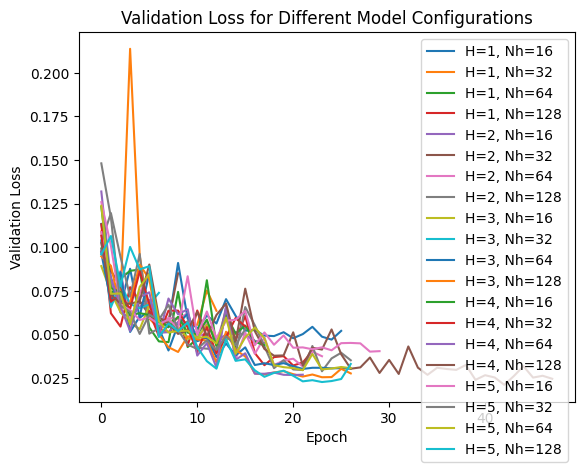

In [11]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_2 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_2.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_2.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_2.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_2.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_2.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_2.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_2 = model_2.fit(X_train, y_train_2, epochs=100, batch_size=32, validation_data=(X_val, y_val_2), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_2[(H, Nh)] = history_2

        # Evaluate the model on the testing set
        predictions_2 = model_2.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_2 = model_2.evaluate(X_test, y_test_2)
        mses_2[(H, Nh)] = mse_2

        # Calculate Mean Absolute Error (MAE)
        mae_2 = mean_absolute_error(y_test_2, predictions_2)
        maes_2[(H, Nh)] = mae_2

        # Calculate Root Mean Squared Error (RMSE)
        rmse_2 = np.sqrt(mean_squared_error(y_test_2, predictions_2))
        rmses_2[(H, Nh)] = rmse_2

        # Calculate R-squared (R2) Score
        r2_2 = r2_score(y_test_2, predictions_2)
        r2_scores_2[(H, Nh)] = r2_2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_2 = np.mean(np.abs((y_test_2 - predictions_2) / y_test_2)) * 100
        mapes_2[(H, Nh)] = mape_2

# Plot the validation loss for each configuration
for (H, Nh), history_2 in histories_2.items():
    plt.plot(history_2.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_2 in mses_2.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_2}')
#     print(f'MAE: {maes_2[(H, Nh)]}')
#     print(f'RMSE: {rmses_2[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_2[(H, Nh)]}')
#     print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [12]:
# Rank combinations based on their MSE values
ranked_combinations_2 = sorted(mses_2.items(), key=lambda x: x[1])

# Print ranked combinations
print('Pl_s1,Pl_s2')
for idx, ((H, Nh), mse_2) in enumerate(ranked_combinations_2, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_2}")


Pl_s1,Pl_s2
Rank 1: Combination H=4, Nh=128 - MSE: 0.021414166316390038
Rank 2: Combination H=5, Nh=128 - MSE: 0.023621421307325363
Rank 3: Combination H=3, Nh=128 - MSE: 0.026602907106280327
Rank 4: Combination H=4, Nh=64 - MSE: 0.02771308273077011
Rank 5: Combination H=2, Nh=128 - MSE: 0.030050793662667274
Rank 6: Combination H=5, Nh=64 - MSE: 0.03043358586728573
Rank 7: Combination H=3, Nh=64 - MSE: 0.031066467985510826
Rank 8: Combination H=2, Nh=64 - MSE: 0.032163430005311966
Rank 9: Combination H=1, Nh=128 - MSE: 0.0325625017285347
Rank 10: Combination H=4, Nh=32 - MSE: 0.04040411487221718
Rank 11: Combination H=5, Nh=16 - MSE: 0.04114217683672905
Rank 12: Combination H=5, Nh=32 - MSE: 0.04215474799275398
Rank 13: Combination H=1, Nh=64 - MSE: 0.04358860105276108
Rank 14: Combination H=4, Nh=16 - MSE: 0.0447705052793026
Rank 15: Combination H=3, Nh=16 - MSE: 0.047061871737241745
Rank 16: Combination H=2, Nh=16 - MSE: 0.04706798121333122
Rank 17: Combination H=1, Nh=16 - MSE: 0.04

## Pl_C

In [13]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_3 = df[["Pl_C"]].values
# Define custom scaling ranges for each input feature

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_3, y_temp_3     = train_test_split(X_scaled, y_3, test_size=0.3, random_state=42)
X_val, X_test, y_val_3, y_test_3 = train_test_split(X_temp, y_temp_3, test_size=0.5, random_state=42)

histories_3 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_3 = {}
maes_3 = {}
rmses_3= {}
r2_scores_3 = {}
mapes_3 = {}

Epoch 1/100, Loss: 0.17877717316150665, Val Loss: 0.01497402973473072
Epoch 2/100, Loss: 0.012932554818689823, Val Loss: 0.008887096308171749
Epoch 3/100, Loss: 0.011413155123591423, Val Loss: 0.008760207332670689
Epoch 4/100, Loss: 0.010620422661304474, Val Loss: 0.008584718219935894
Epoch 5/100, Loss: 0.010544451884925365, Val Loss: 0.007643178571015596
Epoch 6/100, Loss: 0.010311217978596687, Val Loss: 0.01005698461085558
Epoch 7/100, Loss: 0.010547210462391376, Val Loss: 0.008397872559726238
Epoch 8/100, Loss: 0.010112213902175426, Val Loss: 0.007282929960638285
Epoch 9/100, Loss: 0.010331254452466965, Val Loss: 0.008341822773218155
Epoch 10/100, Loss: 0.010048034600913525, Val Loss: 0.008050362579524517
Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping
134/134 [==============================] - 0s 453us/step - loss: 0.0069
Epoch 1/100, Loss: 0.12593430280685425, Val Loss: 0.012168008834123611
Epoch 2/100, Loss: 0.009701421484351158, Val Loss: 0.00

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


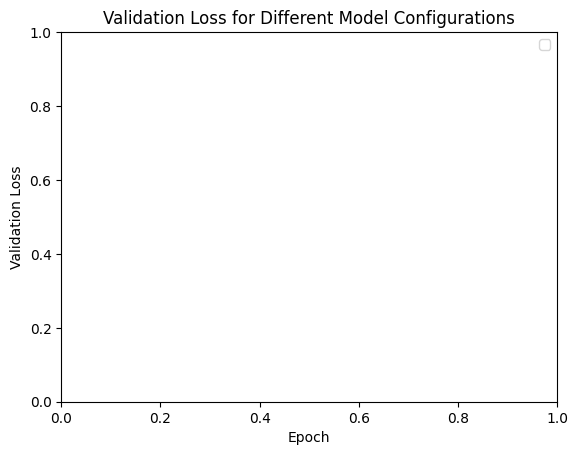

In [14]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_3 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_3.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_3.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_3.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_3.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_3.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_3.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_3 = model_3.fit(X_train, y_train_3, epochs=100, batch_size=32, validation_data=(X_val, y_val_3), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_1[(H, Nh)] = history_3

        # Evaluate the model on the testing set
        predictions_3 = model_3.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_3 = model_3.evaluate(X_test, y_test_3)
        mses_3[(H, Nh)] = mse_3

        # Calculate Mean Absolute Error (MAE)
        mae_3 = mean_absolute_error(y_test_3, predictions_3)
        maes_3[(H, Nh)] = mae_3

        # Calculate Root Mean Squared Error (RMSE)
        rmse_3 = np.sqrt(mean_squared_error(y_test_3, predictions_3))
        rmses_3[(H, Nh)] = rmse_3

        # Calculate R-squared (R2) Score
        r2_3 = r2_score(y_test_3, predictions_3)
        r2_scores_3[(H, Nh)] = r2_3

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_3 = np.mean(np.abs((y_test_3 - predictions_3) / y_test_3)) * 100
        mapes_3[(H, Nh)] = mape_3

# Plot the validation loss for each configuration
for (H, Nh), history_3 in histories_3.items():
    plt.plot(history_3.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_1 in mses_1.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_1}')
#     print(f'MAE: {maes_1[(H, Nh)]}')
#     print(f'RMSE: {rmses_1[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_1[(H, Nh)]}')
#     print(f'MAPE: {mapes_1[(H, Nh)]}%')


In [15]:
# Rank combinations based on their MSE values
ranked_combinations_3 = sorted(mses_3.items(), key=lambda x: x[1])

# Print ranked combinations
print('Pl_C')
for idx, ((H, Nh), mse_3) in enumerate(ranked_combinations_3, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_3}")


Pl_C
Rank 1: Combination H=2, Nh=128 - MSE: 0.0026657746639102697
Rank 2: Combination H=2, Nh=64 - MSE: 0.002734461100772023
Rank 3: Combination H=3, Nh=128 - MSE: 0.003040643408894539
Rank 4: Combination H=5, Nh=32 - MSE: 0.0030764867551624775
Rank 5: Combination H=4, Nh=128 - MSE: 0.003177300561219454
Rank 6: Combination H=3, Nh=64 - MSE: 0.0034651714377105236
Rank 7: Combination H=5, Nh=128 - MSE: 0.003602891694754362
Rank 8: Combination H=1, Nh=64 - MSE: 0.0038780635222792625
Rank 9: Combination H=4, Nh=64 - MSE: 0.00407538004219532
Rank 10: Combination H=5, Nh=64 - MSE: 0.004169289954006672
Rank 11: Combination H=1, Nh=128 - MSE: 0.004178887233138084
Rank 12: Combination H=4, Nh=32 - MSE: 0.004596560262143612
Rank 13: Combination H=3, Nh=32 - MSE: 0.005161371547728777
Rank 14: Combination H=5, Nh=16 - MSE: 0.005265737883746624
Rank 15: Combination H=4, Nh=16 - MSE: 0.005979916546493769
Rank 16: Combination H=3, Nh=16 - MSE: 0.005991936195641756
Rank 17: Combination H=2, Nh=32 - MS

## Pl_L_Cu

In [16]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_4 = df[["Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_4, y_temp_4 = train_test_split(X_scaled, y_4, test_size=0.3, random_state=42)
X_val, X_test, y_val_4, y_test_4 = train_test_split(X_temp, y_temp_4, test_size=0.5, random_state=42)


histories_4 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_4 = {}
maes_4 = {}
rmses_4= {}
r2_scores_4 = {}
mapes_4 = {}

Epoch 1/100, Loss: 0.2046317607164383, Val Loss: 0.1309923231601715
Epoch 2/100, Loss: 0.1455792933702469, Val Loss: 0.11031880974769592
Epoch 3/100, Loss: 0.13828180730342865, Val Loss: 0.09584663808345795
Epoch 4/100, Loss: 0.13416741788387299, Val Loss: 0.09358761459589005
Epoch 5/100, Loss: 0.13255275785923004, Val Loss: 0.10259540379047394
Epoch 6/100, Loss: 0.1331072300672531, Val Loss: 0.0930359810590744
Epoch 7/100, Loss: 0.1283540278673172, Val Loss: 0.08725954592227936
Epoch 8/100, Loss: 0.1301194429397583, Val Loss: 0.0871841236948967
Epoch 9/100, Loss: 0.1284438967704773, Val Loss: 0.0850939080119133
Epoch 10/100, Loss: 0.12736289203166962, Val Loss: 0.08208909630775452
Epoch 11/100, Loss: 0.1220242977142334, Val Loss: 0.08114579319953918
Epoch 12/100, Loss: 0.12793053686618805, Val Loss: 0.0870952382683754
Epoch 13/100, Loss: 0.12308060377836227, Val Loss: 0.09514833986759186
Epoch 14/100, Loss: 0.12285780906677246, Val Loss: 0.08024971932172775
Epoch 15/100, Loss: 0.12203

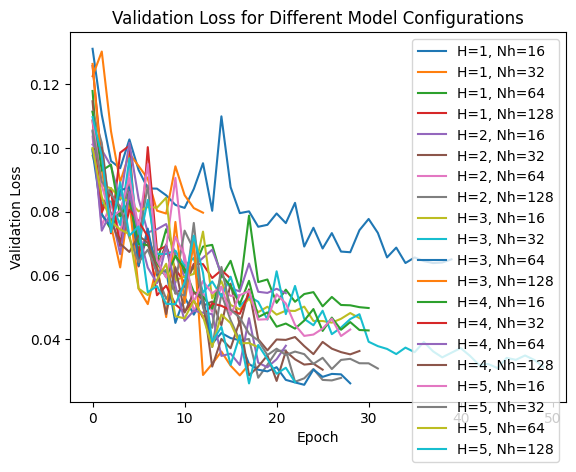

In [17]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_4 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_4.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_4.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_4.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_4.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_4.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_4.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_4 = model_4.fit(X_train, y_train_4, epochs=100, batch_size=32, validation_data=(X_val, y_val_4), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_4[(H, Nh)] = history_4

        # Evaluate the model on the testing set
        predictions_4 = model_4.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_4 = model_4.evaluate(X_test, y_test_4)
        mses_4[(H, Nh)] = mse_4

        # Calculate Mean Absolute Error (MAE)
        mae_4 = mean_absolute_error(y_test_4, predictions_4)
        maes_4[(H, Nh)] = mae_4

        # Calculate Root Mean Squared Error (RMSE)
        rmse_4 = np.sqrt(mean_squared_error(y_test_4, predictions_4))
        rmses_4[(H, Nh)] = rmse_4

        # Calculate R-squared (R2) Score
        r2_4 = r2_score(y_test_4, predictions_4)
        r2_scores_4[(H, Nh)] = r2_4

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_4 = np.mean(np.abs((y_test_4 - predictions_4) / y_test_4)) * 100
        mapes_4[(H, Nh)] = mape_4

# Plot the validation loss for each configuration
for (H, Nh), history_4 in histories_4.items():
    plt.plot(history_4.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_2 in mses_2.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_2}')
#     print(f'MAE: {maes_2[(H, Nh)]}')
#     print(f'RMSE: {rmses_2[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_2[(H, Nh)]}')
#     print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [18]:
# Rank combinations based on their MSE values
ranked_combinations_4 = sorted(mses_4.items(), key=lambda x: x[1])

# Print ranked combinations
print('Pl_L_Cu')
for idx, ((H, Nh), mse_4) in enumerate(ranked_combinations_4, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_4}")


Pl_L_Cu
Rank 1: Combination H=5, Nh=128 - MSE: 0.025806574150919914
Rank 2: Combination H=3, Nh=64 - MSE: 0.026085253804922104
Rank 3: Combination H=4, Nh=128 - MSE: 0.02771727740764618
Rank 4: Combination H=2, Nh=128 - MSE: 0.028069524094462395
Rank 5: Combination H=3, Nh=128 - MSE: 0.029077516868710518
Rank 6: Combination H=3, Nh=32 - MSE: 0.03106619603931904
Rank 7: Combination H=5, Nh=32 - MSE: 0.031652987003326416
Rank 8: Combination H=4, Nh=64 - MSE: 0.032620422542095184
Rank 9: Combination H=2, Nh=32 - MSE: 0.035759855061769485
Rank 10: Combination H=5, Nh=64 - MSE: 0.038975395262241364
Rank 11: Combination H=5, Nh=16 - MSE: 0.041948944330215454
Rank 12: Combination H=4, Nh=16 - MSE: 0.04297824949026108
Rank 13: Combination H=3, Nh=16 - MSE: 0.04545735567808151
Rank 14: Combination H=4, Nh=32 - MSE: 0.046623703092336655
Rank 15: Combination H=2, Nh=64 - MSE: 0.04863091558218002
Rank 16: Combination H=1, Nh=64 - MSE: 0.05056791007518768
Rank 17: Combination H=2, Nh=16 - MSE: 0.05

## P_D

In [19]:
# Extract output (ripples)
# y_1 = df_1[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset
y_5 = df[["P_D"]].values  # Adjust column names as per your dataset

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train_5, y_temp_5 = train_test_split(X_scaled, y_5, test_size=0.3, random_state=42)
X_val, X_test, y_val_5, y_test_5 = train_test_split(X_temp, y_temp_5, test_size=0.5, random_state=42)


histories_5 = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_5 = {}
maes_5 = {}
rmses_5= {}
r2_scores_5 = {}
mapes_5 = {}

Epoch 1/100, Loss: 0.11783243715763092, Val Loss: 0.014219050295650959
Epoch 2/100, Loss: 0.015071477741003036, Val Loss: 0.015668854117393494
Epoch 3/100, Loss: 0.011531956493854523, Val Loss: 0.008265995420515537
Epoch 4/100, Loss: 0.010306947864592075, Val Loss: 0.009457862004637718
Epoch 5/100, Loss: 0.01001940667629242, Val Loss: 0.007908403873443604
Epoch 6/100, Loss: 0.009842543862760067, Val Loss: 0.007098930422216654
Epoch 7/100, Loss: 0.00986327975988388, Val Loss: 0.0096433749422431
Epoch 8/100, Loss: 0.009690599516034126, Val Loss: 0.007156314328312874
Epoch 9/100, Loss: 0.009575906209647655, Val Loss: 0.008086428046226501
Epoch 10/100, Loss: 0.009284207597374916, Val Loss: 0.006549247074872255
Epoch 11/100, Loss: 0.009095987305045128, Val Loss: 0.007798823527991772
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
134/134 [==============================] - 0s 442us/step - loss: 0.0069
Epoch 1/100, Loss: 0.09999578446149826, Val Loss: 0.016

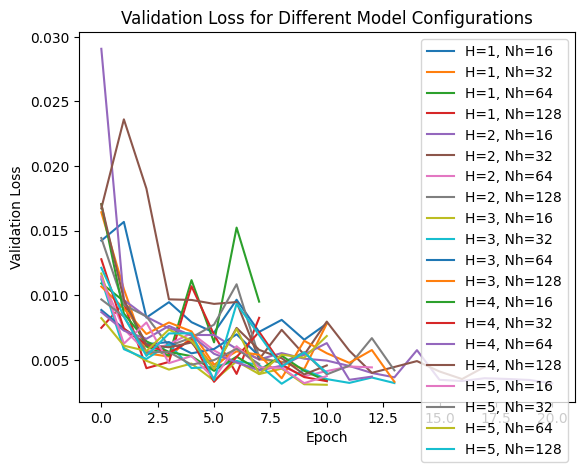

In [20]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_5 = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_5.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model_5.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_5.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_5.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_5.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_5.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history_5 = model_5.fit(X_train, y_train_5, epochs=100, batch_size=32, validation_data=(X_val, y_val_5), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_5[(H, Nh)] = history_5

        # Evaluate the model on the testing set
        predictions_5 = model_5.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse_5 = model_5.evaluate(X_test, y_test_5)
        mses_5[(H, Nh)] = mse_5

        # Calculate Mean Absolute Error (MAE)
        mae_5 = mean_absolute_error(y_test_5, predictions_5)
        maes_5[(H, Nh)] = mae_5

        # Calculate Root Mean Squared Error (RMSE)
        rmse_5 = np.sqrt(mean_squared_error(y_test_5, predictions_5))
        rmses_5[(H, Nh)] = rmse_5

        # Calculate R-squared (R2) Score
        r2_5 = r2_score(y_test_5, predictions_5)
        r2_scores_5[(H, Nh)] = r2_5

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_5 = np.mean(np.abs((y_test_5 - predictions_5) / y_test_5)) * 100
        mapes_5[(H, Nh)] = mape_5

# Plot the validation loss for each configuration
for (H, Nh), history_5 in histories_5.items():
    plt.plot(history_5.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# # Print the evaluation metrics for each configuration
# for (H, Nh), mse_2 in mses_2.items():
#     print(f'Model with H={H} and Nh={Nh}:')
#     print(f'MSE: {mse_2}')
#     print(f'MAE: {maes_2[(H, Nh)]}')
#     print(f'RMSE: {rmses_2[(H, Nh)]}')
#     print(f'R-squared: {r2_scores_2[(H, Nh)]}')
#     print(f'MAPE: {mapes_2[(H, Nh)]}%')


In [21]:
# Rank combinations based on their MSE values
ranked_combinations_5 = sorted(mses_5.items(), key=lambda x: x[1])

# Print ranked combinations
print('P_D')
for idx, ((H, Nh), mse_5) in enumerate(ranked_combinations_5, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_5}")


P_D
Rank 1: Combination H=3, Nh=32 - MSE: 0.003178824670612812
Rank 2: Combination H=4, Nh=32 - MSE: 0.003270919667556882
Rank 3: Combination H=3, Nh=16 - MSE: 0.0033316086046397686
Rank 4: Combination H=2, Nh=16 - MSE: 0.003352891420945525
Rank 5: Combination H=5, Nh=128 - MSE: 0.003379280911758542
Rank 6: Combination H=5, Nh=16 - MSE: 0.00355010898783803
Rank 7: Combination H=3, Nh=128 - MSE: 0.0035844400990754366
Rank 8: Combination H=2, Nh=32 - MSE: 0.003920267336070538
Rank 9: Combination H=4, Nh=16 - MSE: 0.00409071147441864
Rank 10: Combination H=4, Nh=64 - MSE: 0.004149691201746464
Rank 11: Combination H=2, Nh=64 - MSE: 0.0042191362008452415
Rank 12: Combination H=5, Nh=64 - MSE: 0.004303904250264168
Rank 13: Combination H=1, Nh=128 - MSE: 0.004323766566812992
Rank 14: Combination H=4, Nh=128 - MSE: 0.004356402438133955
Rank 15: Combination H=1, Nh=32 - MSE: 0.0045043607242405415
Rank 16: Combination H=2, Nh=128 - MSE: 0.004761681891977787
Rank 17: Combination H=1, Nh=64 - MSE:

# All

In [22]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw']].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling_1(X)


# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5]  # Number of hidden layers
Nh_values = [16, 32, 64, 128]  # Number of neurons per hidden layer

Epoch 1/100, Loss: 528.870361328125, Val Loss: 347.7948913574219
Epoch 2/100, Loss: 311.52435302734375, Val Loss: 175.56878662109375
Epoch 3/100, Loss: 206.42718505859375, Val Loss: 109.4480209350586
Epoch 4/100, Loss: 146.46908569335938, Val Loss: 65.46342468261719
Epoch 5/100, Loss: 110.19268035888672, Val Loss: 41.38894271850586
Epoch 6/100, Loss: 86.54236602783203, Val Loss: 27.81524658203125
Epoch 7/100, Loss: 70.13321685791016, Val Loss: 18.71198272705078
Epoch 8/100, Loss: 56.88805389404297, Val Loss: 15.601424217224121
Epoch 9/100, Loss: 49.482322692871094, Val Loss: 17.83223533630371
Epoch 10/100, Loss: 44.07126998901367, Val Loss: 14.012280464172363
Epoch 11/100, Loss: 40.961448669433594, Val Loss: 18.453519821166992
Epoch 12/100, Loss: 36.5408821105957, Val Loss: 20.402084350585938
Epoch 13/100, Loss: 31.93173599243164, Val Loss: 17.832868576049805
Epoch 14/100, Loss: 34.850990295410156, Val Loss: 20.55087661743164
Epoch 15/100, Loss: 30.701173782348633, Val Loss: 24.9134902

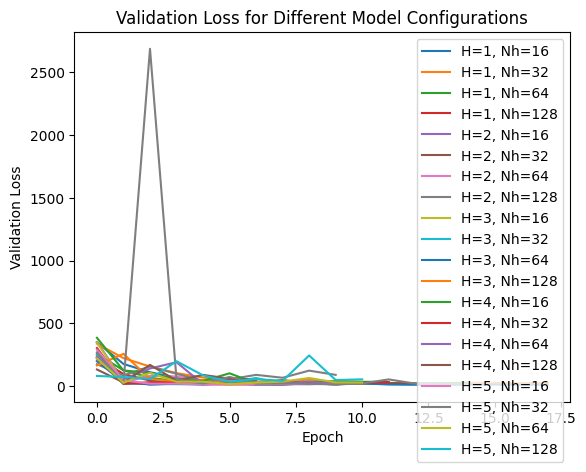

Model with H=1 and Nh=16:
MSE: 17.27845001220703
MAE: 1.2876858112053526
RMSE: 4.156735101814453
R-squared: 0.33303461801953954
MAPE: 142.52682197123326%
Model with H=1 and Nh=32:
MSE: 17.301223754882812
MAE: 1.2700236702584384
RMSE: 4.159473755026887
R-squared: 0.24278974637937542
MAPE: 46.03785848361465%
Model with H=1 and Nh=64:
MSE: 15.019758224487305
MAE: 1.1798889384698603
RMSE: 3.875533153168084
R-squared: 0.5129672245799157
MAPE: 44.29355130949586%
Model with H=1 and Nh=128:
MSE: 13.990234375
MAE: 1.055481592895517
RMSE: 3.7403524801082564
R-squared: 0.5217284622513089
MAPE: 42.16862557999016%
Model with H=2 and Nh=16:
MSE: 13.787875175476074
MAE: 1.1207688628238532
RMSE: 3.713203474161675
R-squared: -0.16074412633157847
MAPE: 183.25435298647622%
Model with H=2 and Nh=32:
MSE: 18.909378051757812
MAE: 1.219058745853523
RMSE: 4.348491501915212
R-squared: -1.0323938797875876
MAPE: 341.9964752686853%
Model with H=2 and Nh=64:
MSE: 25.21451759338379
MAE: 1.4978815071687246
RMSE: 5.0

In [23]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(3,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(6, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


In [24]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=3, Nh=64 - MSE: 11.658246994018555
Rank 2: Combination H=3, Nh=32 - MSE: 12.713284492492676
Rank 3: Combination H=4, Nh=64 - MSE: 13.03161907196045
Rank 4: Combination H=2, Nh=16 - MSE: 13.787875175476074
Rank 5: Combination H=5, Nh=32 - MSE: 13.984490394592285
Rank 6: Combination H=1, Nh=128 - MSE: 13.990234375
Rank 7: Combination H=3, Nh=128 - MSE: 14.157942771911621
Rank 8: Combination H=3, Nh=16 - MSE: 14.861740112304688
Rank 9: Combination H=1, Nh=64 - MSE: 15.019758224487305
Rank 10: Combination H=5, Nh=16 - MSE: 15.453019142150879
Rank 11: Combination H=5, Nh=64 - MSE: 16.805171966552734
Rank 12: Combination H=1, Nh=16 - MSE: 17.27845001220703
Rank 13: Combination H=1, Nh=32 - MSE: 17.301223754882812
Rank 14: Combination H=2, Nh=32 - MSE: 18.909378051757812
Rank 15: Combination H=4, Nh=32 - MSE: 20.155410766601562
Rank 16: Combination H=2, Nh=64 - MSE: 25.21451759338379
Rank 17: Combination H=4, Nh=128 - MSE: 25.328418731689453
Rank 18: Combination H=5, Nh=

# Try spesific N and H

In [25]:
# Specify the combination you want to call
H = 7
Nh = 512

# Retrieve the model for the specified combination
selected_model_1 = histories_1[(H, Nh)].model
selected_model_1.save("model_7_512_13_13.h5")
# Use the trained model to make predictions on the testing set
predictions_1 = selected_model_1.predict(X_test)

# Evaluate the model on the testing set
mse_1 = selected_model_1.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse_1)

# Print the first few predictions
print("Predictions:")
print(predictions_1[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

KeyError: (7, 512)